# Imports

In [9]:
import numpy as np
import sympy as sp
from sympy import *
import re

import matplotlib.pyplot as plt
import matplotlib.colors as c
from matplotlib.ticker import PercentFormatter
from matplotlib import rcParams

from math import log10, floor
from math import *
import math

from IPython.display import display, Latex
from IPython.display import Markdown as md

import scipy.constants as pc
from scipy.optimize import curve_fit
from scipy.optimize import minimize
from scipy import stats

# Matplotlib Style changes

In [10]:
rcParams['font.size'] = 15
rcParams['font.weight'] = 'bold'
rcParams['text.usetex'] = True
rcParams['axes.grid'] = True
rcParams['font.family'] = 'serif'
rcParams['font.sans-serif'] = ['Latin Modern Math']
rcParams['xtick.labelsize'] = 18
rcParams['ytick.labelsize'] = 18
rcParams["xtick.minor.size"] =  4
rcParams["ytick.minor.size"] =  4
rcParams["xtick.minor.visible"] =  True
rcParams["ytick.minor.visible"] =  True

# Selfcoded functions

In [11]:
# mean value
def am(werte):
    return np.mean(werte)

# stdandard deviation
def std(werte):
    summen_der_quadrate = 0
    for wert in werte:
        summen_der_quadrate+=(wert-am(werte))**2       
    return np.sqrt(summen_der_quadrate/(werte.size-1))

# standard error
def stu(werte):
    return std(werte)/np.sqrt(werte.size)

# gaussian error propogation
def fehler(f, werte, unsicherheiten, variablen):
    zMax = 0
    for i in range(werte.size):
        dif = np.abs(sy.diff(f, variablen[i]))
        zMax += (dif * unsicherheiten[i])**2
    zMax = sqrt(zMax)
    for j in range(werte.size):
        zMax = sub(zMax, variablen[j], werte[j])
    return zMax

# what error makes up the most of the resulting error in error propogation
def groessterBeitrag(f, werte, unsicherheiten, variablen):
    zMax = 0
    zMaxArray = np.array([])
    for i in range (werte.size):
        zMax = (np.abs(sy.diff(f, variablen[i])) * unsicherheiten[i])
        for j in range(werte.size):
            zMax = sub(zMax, variablen[j], werte[j])
        x = np.array([zMax])
        zMaxArray = np.append(zMaxArray, x)
    return variablen[np.argmax(zMaxArray)], zMaxArray[np.argmax(zMaxArray)]

# quality of life subsitution function for sympy tp substitute multiple variables at once
def sub(zMax, variable, wert):
    return zMax.subs([(variable, wert)])

# easier formula for gaussian error propagation with addition
def einfachGaussAdd(unsicherheiten, koeffizienten):
    dz = 0
    for i in range (unsicherheiten.size):
        dz += (koeffizienten[i]*unsicherheiten[i])**2
    return sqrt(dz)

# easier formula for gaussian error propagation with multiplication
def einfachGaussMult(unsicherheiten, werte, exponenten):
    dz = 0
    for i in range (unsicherheiten.size):
        dz += (exponenten[i]*unsicherheiten[i]/werte[i])**2
    return sqrt(dz)

# Formlae for Gaußen Error propagation with result
def DivisionMitFehler(A, deltaA, B, deltaB): # Für C=A/B
    C = A/B
    deltaC = abs(C) * math.sqrt((deltaA / A)**2 + (deltaB / B)**2)
    return C,deltaC

def MultiplikationMitFehler(A, deltaA, B, deltaB): #Für C=A*B
    C = A * B
    deltaC = abs(C) * ((deltaA / abs(A)) + (deltaB / abs(B)))
    return C, deltaC

# t-value for without literature value
def vertraeglichkeit(am_1, am_2, stu_1, stu_2):
    return (np.abs(am_1-am_2)/(sqrt((stu_1**2)*(stu_2**2))))

# analytic linear regression y(x)=m*x + b calculates m
def bestM(x, y):
    return (x.size*sum(x*y)-sum(x)*sum(y))/(x.size*sum(x**2)-sum(x)**2)

# analytic linear regression y(x)=m*x + b calculates b
def bestB(x, y):
    return (sum(x**2)*sum(y)-sum(x)*sum(x*y))/(x.size*sum(x**2)-sum(x)**2)

# analytic linear regression calculates variance 
# (only used for next two functions, never gets called on its own, ehances readability) 
def streuung(x, y):
    s = 0
    for i in range(x.size):
        s += (y[i]-(bestB(x, y)+bestM(x, y)*x[i]))**2
    return np.sqrt(s/(x.size-2))

# analytic linear regression y(x)=m*x + b calculates error on m
def stuM(x, y):
    s = streuung(x, y)
    return s*np.sqrt(x.size/((x.size*sum(x**2)-sum(x)**2)))

# analytic linear regression y(x)=m*x + b calculates error on b
def stuB(x, y):
    s = streuung(x, y)
    return s*np.sqrt(sum(x**2)/((x.size*sum(x**2)-sum(x)**2)))


# Versuch Lichtlaufzeiten

Wichtige Anmerkungen zu den Codekonventionen:
- Variablennamen nutzen CamelCase und kürzen ab z.B.: linsenAbstandGegenstand was dem Abstand der Linse von der Gegenstandseite entspricht
- Fehler werden hierbei mit dem Suffix Err im CamelCase gekennzeichnet z.B.: abstandErr entspricht dem Fehler der Abstandsvariable 
- Einheiten stehen kommentiert nach den Einheiten z.B.: x = 3 # mm oder "vMax = 2 # V"


## 1. Methode: Optischer Chopper

Bei der ersten Methode wurde der Lichtstrahl mithilfe eines optischen Choppers unterbrochen, der dadurch entstandene Lichtpuls wurde an einem Spiegel zurück in eine Photodiode reflektiert und passierte dabei eine Strecke von $\Delta s = 0.848 \pm 0.005 $m. Damit der Laserstrahl am Ort des Choppers optimal fokussiert war, wurde die Brennweite einer Linse berechnet, und diese so installiert, dass ihr Brennpunkt mit der Chopperdisk kongruent war. Die resultierenden Spannung der Photodiode wurden mithilfe des LeCroy Lt344L Oszilloskops ausgelesen

### Brennweite der Linse berechnen

In [12]:
# Funktion zur Berechnung der Brennweite
def brennweite(g, b):
    return 1/(1/g+1/b)


# Abstandsmessungen
abstandGegenstandLinse = 130 # mm
abstandLinseSchirm = 65      # mm

linsenAbstandGegenstand = 7      # mm
linsenAbstandSchirm = 3          # mm

# Fehler aller Abstandsmessungen
abstandErr = 1 # mm

# Berechnung der Brennweite
brennweite = brennweite(abstandGegenstandLinse+linsenAbstandGegenstand, abstandLinseSchirm+linsenAbstandSchirm)

# Berechnung des Fehlers der Brennweite mit Gausscher Fehlerforpflanzung
brennweiteErr = einfachGaussAdd(np.array([abstandErr,abstandErr]),np.array([1,1]))


md(f"Brennweite mit Fehler: ${brennweite:.1f} \pm {brennweiteErr:.1f}$ [mm]")

Brennweite mit Fehler: $45.4 \pm 1.4$ [mm]

### Dateneingabe der ersten Messreihe Chopper

In [13]:
# Gemessene Spannungen

# Vollständige Messung
# spannungen = np.array([208, 197, 189, 179, 167, 155, 144, 135, 127, 117, 111, 104, 98, 93, 89, 85, 81, 
#                        78, 74, 71, 69, 66, 64, 62, 59, 58, 53, 48, 46, 42, 40, 38, 37, 34, 33, 32, 30])  # mV

# Ausgewählter Bereich
spannungen = np.array([53, 48, 46, 42, 40, 38, 37, 34, 33, 32, 30])

# Fehler der Spannungen (durch Variation am Oszilloskop geschätzt)
spannungenErr = 2 # mV

# Dazugehörige Frequenzen
#frequenzenKlein = np.arange(150, 4050, 150)                    # Hz
frequenzenGroß = np.arange(4500, 10000, 500)                    # Hz
frequenzen = np.concatenate((np.array([]), frequenzenGroß))     # Hz

# Fehler der Frequenzen
frequenzenErr = 20 # Hz

### Fit berechnen

In [14]:
frequenzBereich = np.arange(0, 60001, 1)

# Cosinusfunktion 
def myCos(x, f, p):
    return 3359420*np.cos(f*x+p) + 3359420

# Fitfunktion
def fitCos(p0, x, y):
    fit = curve_fit(myCos, x, y, p0=p0, maxfev = 10000000)
    data_fit = myCos(frequenzBereich, *fit[0])
    minPoint = np.array([data_fit.argmin(), min(data_fit)]) 
    return data_fit, minPoint

# Anfangswerte für den fit (geraten)
freqGuess = 1/(340000*pc.pi)
phaseGuess = pi/1.0035
p0 = np.array([freqGuess, phaseGuess] )

# Berechnen der gefitteten Werte
fitWerte, minPoint = fitCos(p0,frequenzen,spannungen)

### Anzeigen der Daten

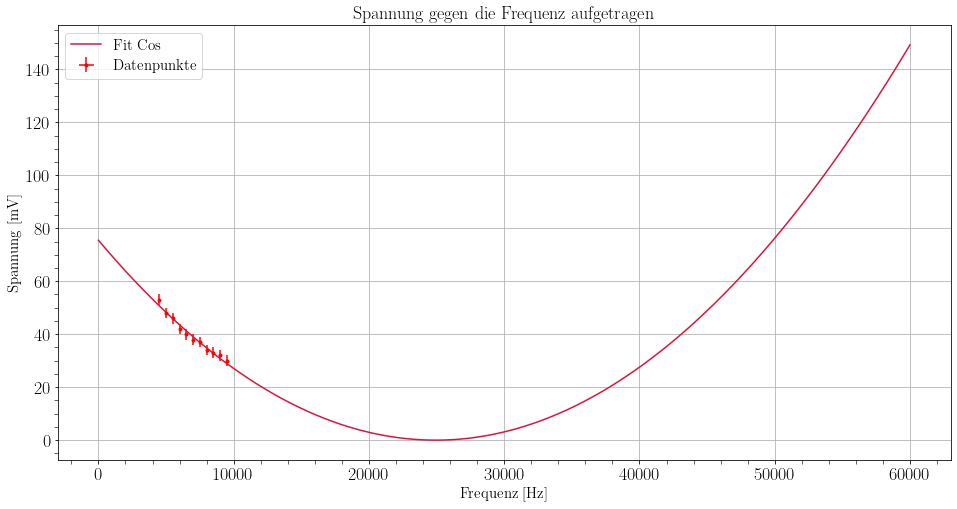

Minimalpunkt liegt bei: $24935.0 \pm 0$ [Hz]
  
   Dies entspricht einer Lichtgeschwindigkeit von: $21144.9 \pm 0$ [m/s]

In [15]:
# Plotgröße anpassen
plt.figure(figsize=(16, 8))    

# Gemessene Spannungswerte auftragen
plt.errorbar(frequenzen, spannungen, xerr=frequenzenErr, yerr=spannungenErr, 
             fmt='.', color='red', label='Datenpunkte', marker=None)

# Angepasste Cosinusfunktion aufzeichnen
plt.plot(frequenzBereich, fitWerte, color='crimson', label='Fit Cos',marker=None)

# labels und legend
plt.xlabel(r'Frequenz [Hz]')
plt.ylabel(r'Spannung [mV]')
plt.legend()

# Plot anzeigen lassen
plt.grid(True)
plt.title('Spannung gegen die Frequenz aufgetragen')
plt.show()

# Ausgabe des Hz-Werts für den Minimalpunkt
md(f"""Minimalpunkt liegt bei: ${minPoint[0]:.1f} \pm {0}$ [Hz]\n  
   Dies entspricht einer Lichtgeschwindigkeit von: ${minPoint[0]*0.848:.1f} \pm {0}$ [m/s]""")

### Dateneingabe der zweiten Messreihe Chopper

In [16]:
# Gemessene Spannungen

# Vollständige Messung
# spannungen2 = np.array([600, 395, 285, 224, 184, 161, 143, 129, 116, 108, 95, 72, 66, 62, 58, 55, 52, 49, 47, 45])  # mV

# Ausgewählter Bereich
spannungen2 = np.array([72, 66, 62, 58, 55, 52, 49, 47, 45])  # mV

# Fehler der Spannungen (durch Variation am Oszilloskop geschätzt)

# Vollständige Messung
#spannungen2Err = np.array([5,4,4, 4, 4, 4, 4, 4, 4, 4, 1, 1, 1, 1, 1, 1, 1, 1, 1])  # mV

# Im ausgewählten Bereich
spannungen2Err = 1 # mV

# Dazugehörige Frequenzen
frequenzen2 = np.arange(12, 21, 1)*1e3   # Hz

# Fehler der Frequenzen
frequenzen2Err = 20 # Hz

### Fit berechnen

In [17]:
# Frequenzbereich festlegen
frequenzBereich2 = np.arange(0, 60001, 1)

# Cosinusfunktion 
def myCos(x, f, p):
    return 3359420*np.cos(f*x+p) + 3359420


# Fitfunktion
def fitCos(p0, x, y):
    fit = curve_fit(myCos, x, y, p0=p0, maxfev = 10000000)
    data_fit = myCos(frequenzBereich, *fit[0])
    minPoint = np.array([data_fit.argmin(), min(data_fit)]) 
    return data_fit, minPoint

# Anfangswerte für den fit (geraten)
freqGuess = 2e-07
ampGuess = 3000000
phaseGuess = 3.1325
offsetGuess = 3000050
p0 = np.array([freqGuess, phaseGuess])

# Berechnen der gefitteten Werte
fitWerte2, minPoint2 = fitCos(p0,frequenzen2,spannungen2)

### Anzeigen der Daten

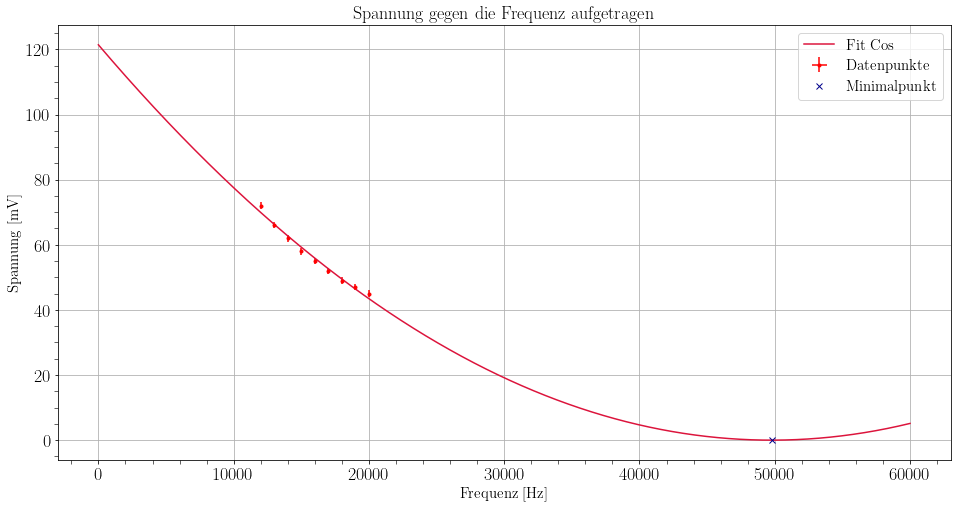

Minimalpunkt liegt bei: $49766.0 \pm 0$ [Hz]

   Dies entspricht einer Lichtgeschwindigkeit von: $42201.6 \pm 0$ [m/s]

In [18]:
# Plotgröße anpassen
plt.figure(figsize=(16, 8))  

# Gemessene Spannungswerte auftragen
plt.errorbar(frequenzen2, spannungen2, xerr=frequenzen2Err, yerr=spannungen2Err, 
             fmt='.', color='red', label='Datenpunkte', marker=None)

# Angepasste Cosinusfunktion aufzeichnen
plt.plot(frequenzBereich2, fitWerte2, color='crimson', label='Fit Cos',marker=None)

# Minimalpunkt
plt.errorbar(minPoint2[0], minPoint2[1], color='darkblue', label='Minimalpunkt', fmt='x')

# labels und legend
plt.xlabel(r'Frequenz [Hz]')
plt.ylabel(r'Spannung [mV]')
plt.legend()

# Plot anzeigen lassen
plt.grid(True)
plt.title('Spannung gegen die Frequenz aufgetragen')
plt.show()

# Ausgabe des Hz-Werts für den Minimalpunkt
md(f"""Minimalpunkt liegt bei: ${minPoint2[0]:.1f} \pm {0}$ [Hz]\n
   Dies entspricht einer Lichtgeschwindigkeit von: ${minPoint2[0]*0.848:.1f} \pm {0}$ [m/s]""")

## 2. Methode Funktionsgenerator
Die gesamte Strecke, welche das Licht zurücklegt wird entsprechend der Skizze mit der Formel

$$L = A + B + C + \sqrt{F^2+C^2}$$

bestimmt. Für den Fehler haben wir auf jede Messung einen Wert von $\Delta = 0.002$m geschätzt, bei diesem Werthandeölt es sich um einen statistischen Fehler, da er sich nicht nach der Skalenauflösung des Messinstruments richtet (das Messinstrument war ein Bandmaß mit einer Skalenauflösung von 1mm), sondern nach der Ungenauigkeit der vermessenden Person. Mittels der Gaußschen Fehlerfortpflanzung ergibt sich aus diesem Fehler dann ein Fehler für die gesamte Länge von 

$$\Delta L=\sqrt{0.006\text{m}+0.002\text{m}(F^{2}+C^{2})^{-\frac{1}{2}}(F+C)}$$

Der Fehler auf den Delay wurde mit $\Delta Delay = 0.2$ns geschätzt.

In [19]:
# Funktion zum Berechnen der Lichtlaufstrecke
def bestimmungLichtLaufstrecke(C):
    return np.sqrt(F**2+C**2) + A + B + C

# Funktion zum Berechnen des Fehlers auf die Lichtlaufstrecke mittels Gaußscher Fehlerfortpflanzung
def bestimmungLichtLaufstreckeErr(C): 
    return np.sqrt(0.006+0.002*(F**2+C**2)**(-1/2)*(F+C))

# Längen des Aufbaus:
A,B,F = 0.763, 0.750, 0.065                                 # m
MessungenC = np.array([0.74,0.64,0.54,0.44,0.34,0.24,0.14]) # m
StreckenmessungErr = 0.002                                  # m

# Gemessene Delays mit Average, min und max, abgelesen vom Oszilloskop
delayAverage = np.array([10.2,9.9,9.7,9.4,9,8.3,7.6]) * 10**-9 # s
delayMin = np.array([9.6,9.6,9.3,9.3,8.8,7.2,7.0]) * 10**-9    # s
delayMax = np.array([10.6,10.2,9.9,9.9,9.6,10.9,9.4]) * 10**-9 # s
delayErr = 0.2 * 10**-9                                        # s

# Berechnen Gesamt Länge und Fehler
LichtLaufstrecke2 = bestimmungLichtLaufstrecke(MessungenC)
LichtLaufstrecke2Err = bestimmungLichtLaufstreckeErr(MessungenC)

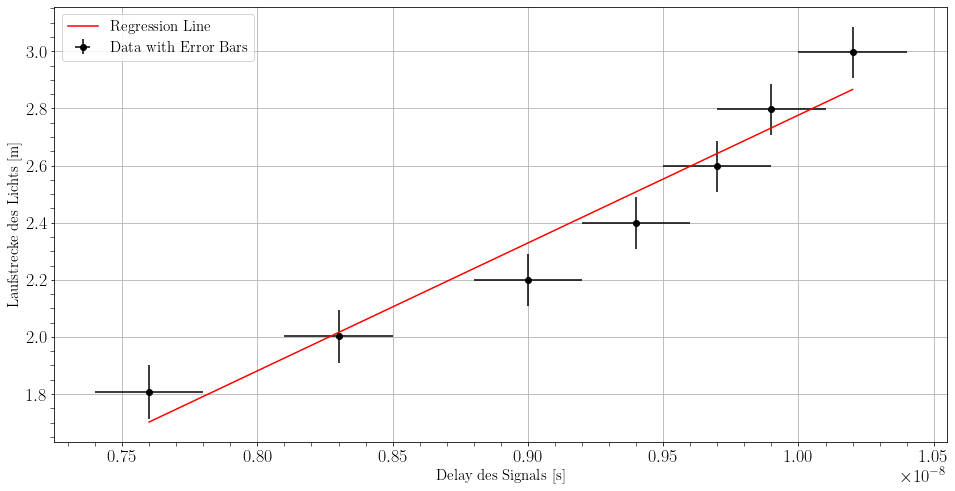

Die Steigung der Gerade, welche dem von uns gemessenen Wert der Lichtgeschwindigkeit Entspricht
ergibt sich als: $447730281.2 \pm 0$ [Hz]

In [25]:
# Plotten der Daten und Lineare Regression
bTeil2 = bestB(delayAverage,LichtLaufstrecke2)
mTeil2 = bestM(delayAverage,LichtLaufstrecke2)

#Fehler der Linearen Regression bestimmen


# Plotgröße anpassen
plt.figure(figsize=(16, 8))    

# Zeichnen der Datenpunkte in schwarz
plt.errorbar(delayAverage, LichtLaufstrecke2, yerr=LichtLaufstrecke2Err,
             xerr=delayErr, fmt='o', label='Data with Error Bars', color='black')

# Zeichnen der linearen Ausgleichsgerade in rot
plt.plot(delayAverage, mTeil2 * delayAverage + bTeil2, color='red', label='Regression Line')

# Achsenbeschriftungen
plt.xlabel(r'Delay des Signals [s]')
plt.ylabel(r'Laufstrecke des Lichts [m]')

plt.legend()
plt.show()

# Ausgabe des Hz-Werts für den Minimalpunkt
md(f"""Die Steigung der Gerade, welche dem von uns gemessenen Wert der Lichtgeschwindigkeit Entspricht
ergibt sich als: ${mTeil2:.1f} \pm {0}$ [Hz]""")

## 3. Pulslaser
Statt des einfachen Laserpointers wurde nun der Pulslaser angeschlossen, welcher mittels des Funktionsgenerator gesteuert wurde. 
Diesmal wurde nur der abstand D variiert. Es ergibt sich also für die Lichtlauflänge

$$L=A+B+C+D$$

Für den fehler ergibt sich 

$$\Delta L = \sqrt{4\cdot0.002\text{m}}=0.004\text{m}$$

In [21]:
# Daten eingeben

# Lichtlaufstrecke
A, B, C = 0.565, 0.782, 0.815
MessungenD = np.array([60,50,40,30,20,10])*0.01
fehlerStreckenmessung = 0.002

LichtLaufstrecke3 = MessungenD + A + B + C
LichtLaufstrecke3Err = np.sqrt(4*0.002)

#gemessene Delays mit Fehler
MessungDelay3 = np.array([12,11,10,9,7.6,5]) * 10**-9
MessungDelay3Err = np.array([1,1,1,1,0.5,2]) * 10**-9 

Ergebnis für die Lichtgeschwindigketit 72413793.10344855


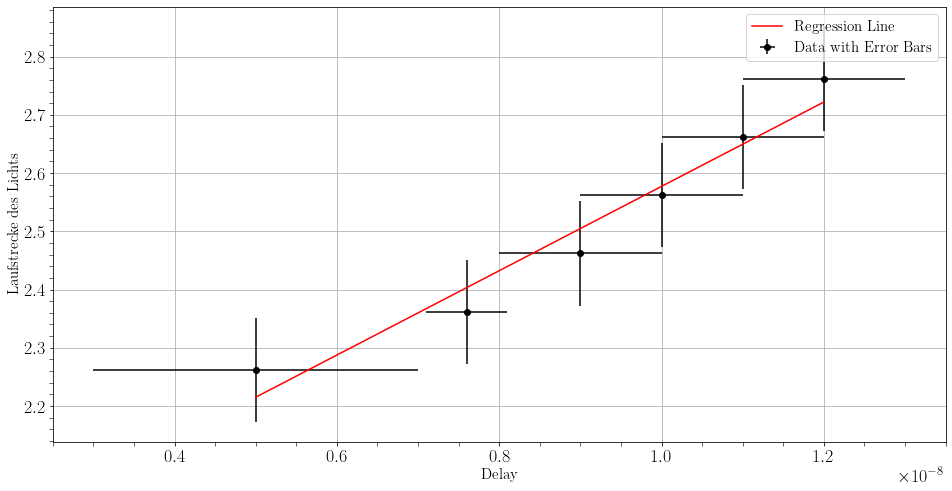

In [22]:
# Daten Plotten mit Errorbars

bTeil3 = bestB(MessungDelay3,LichtLaufstrecke3)
mTeil3 = bestM(MessungDelay3,LichtLaufstrecke3)

# Plotgröße anpassen
plt.figure(figsize=(16, 8))    

# Datenpunkte einzeichnen
plt.errorbar(MessungDelay3, LichtLaufstrecke3, yerr=LichtLaufstrecke3Err, xerr=MessungDelay3Err, 
             fmt='o', label='Data with Error Bars', color='black')

# Ausgleichsgerade einzeichnen
plt.plot(MessungDelay3, mTeil3 * MessungDelay3 + bTeil3, color='red', label='Regression Line')

#Ausgabe des Eregebnisses für die Lichtgeschwindigkeit
print("Ergebnis für die Lichtgeschwindigketit",mTeil3)

# Achsenbeschriftungen
plt.xlabel('Delay ')
plt.ylabel('Laufstrecke des Lichts')

plt.legend()
plt.show()

# Verbesserte Messmethoden

In [ ]:
MaximaleFrequenz = 20090
MaximaleFrequenzErr = 10

MinimaleZeit = DivisionMitFehler(1, 0, MaximaleFrequenz, MaximaleFrequenzErr)[0]
MinimaleErr = DivisionMitFehler(1, 0, MaximaleFrequenz, MaximaleFrequenzErr)[1]

Lichtgeschwindigkeit = 299792458

# Minimal nötige Strecke für komplettes verschwinden des Signals bei gleicher Maximaler Frequenz

minDistanz = MultiplikationMitFehler(Lichtgeschwindigkeit, 0, MinimaleZeit, MinimaleZeitErr)[0]
minDistanzErr = MultiplikationMitFehler(Lichtgeschwindigkeit, 0, MinimaleZeit, MinimaleZeitErr)[1]

minDistanz,minDistanzErr

# Minimal nötige Frequenz für das verschwinden des Signals bei gleicher Strecke

Distanz = 

